# Recommendation System

## Obtain the movie lens dataset from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip It contains 100,000 ratings applied to 9,000 movies by 600 users. Refer the readme file in the dataset.

## Task 1: Read the dataset files and load them in appropriate data structure and display top-5 rows in each of them ( 2 marks )

In [1]:
import requests
import zipfile, io
import pandas as pd

# Read and extract the zip directly
zipfile.ZipFile(io.BytesIO(requests.get("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip").content)).extractall("./")

# Read all the csv files
tags = pd.read_csv("ml-latest-small/tags.csv")
links = pd.read_csv("ml-latest-small/links.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

# Display top 5 records from all files
display(links.head(), movies.head(), ratings.head(), tags.head())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Task 2: Print CDF plot of average ratings given by users. X-axis is value of average ratings, and Y-axis is the cumulative frequency ( 2 marks )

,0,1,2,3,4,5,6,7,8,9
rating,0.500000,1.000000,1.500000,2.000000,2.500000,3.000000,3.500000,4.000000,4.500000,5.0
Count,1370.000000,2811.000000,1791.000000,7551.000000,5550.000000,20047.000000,13136.000000,26818.000000,8551.000000,13211.0
Cumsum,0.013586,0.041463,0.059225,0.134109,0.189149,0.387957,0.518228,0.784184,0.868985,1.0


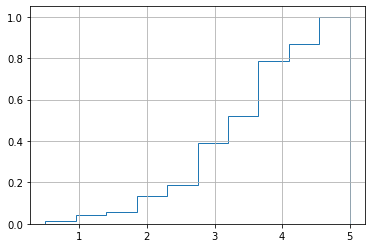

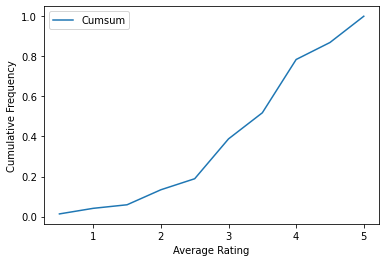

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate cumulative frequency and distribution
cdf = pd.DataFrame(ratings.groupby(ratings.rating).size(), columns=["Count"]).reset_index()
cdf['Cumsum'] = (cdf.Count/sum(cdf.Count)).cumsum()
display(cdf.T)

# Show rating histogram and density
ratings.rating.hist(cumulative=True, density=True, histtype='step', bins=10)
plt.show()

# CDF Plot
cdf.plot(x='rating', y=['Cumsum'])
plt.xlabel('Average Rating')
plt.ylabel('Cumulative Frequency')
plt.show()

## Task 3: Arrange users in increasing order of the average ratings they have given. Select a user (X1) at 30 percentile and print the movies and corresponding movies ratings given by X1 ( 2 marks )

In [3]:
import numpy as np
arrangedUsers = ratings.groupby(ratings.userId).rating.mean().sort_values(ascending=True)
#arrangedUsers.quantile(0.3)
X1 = arrangedUsers[arrangedUsers == np.percentile(arrangedUsers, 30, interpolation="nearest")].index[0] 
X1_ratings = movies.merge(ratings, on='movieId')
display(X1_ratings[X1_ratings.userId == X1][["title","rating"]])

,title,rating
620,GoldenEye (1995),5.0
2862,From Dusk Till Dawn (1996),3.5
3398,Braveheart (1995),0.5
3986,Bad Boys (1995),1.0
4725,Desperado (1995),3.0
...,...,...
78603,Ong-Bak: The Thai Warrior (Ong Bak) (2003),5.0
79095,Appleseed (Appurushîdo) (2004),3.0
79233,Hitch (2005),2.0
82245,Hard Candy (2005),4.5


## Task 4: Find top-5 users "similar" to this user (X1) based on movie ratings. Clearly mention (in comments) your criteria to compute similarity. ( 4 marks )

In [4]:
from math import pow, sqrt

# Getting the rating given by a user to a movie
def get_rating_(userid,movieid):
    return (ratings.loc[(ratings.userId==userid) & (ratings.movieId == movieid),'rating'].iloc[0])

# Getting the list of all movie ids the specified user has rated
def get_movieids_(userid):
    return (ratings.loc[(ratings.userId==userid),'movieId'].tolist())

# Getting the movie titles against the movie id
def get_movie_title_(movieid):
    return (movies.loc[(movies.movieId == movieid),'title'].iloc[0])

# This euclidean measure has a problem as we do not have a threshold to decide how much distance between two users is
# to be considered for calculating whether the users are close enough or far enough. This problem is resolved by
# pearson correlation method as it always returns a value between -1 & 1 which clearly provides us with the boundaries
# for closeness as we prefer.

# For reference, not used due to above reason
def distance_similarity_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    # Count of movies watched by both the users.
    both_watch_count = 0
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            both_watch_count += 1
    if both_watch_count == 0 :
        return 0
    
    # Calculating distance based similarity between both the users.
    distance = []
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            rating1 = get_rating_(user1,element)
            rating2 = get_rating_(user2,element)
            distance.append(pow(rating1 - rating2, 2))
    total_distance = sum(distance)
    
    # Adding one to the denominator to avoid divide by zero error.
    return 1/(1+sqrt(total_distance))

# Pearson Similarity used to calculate distance
def pearson_correlation_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    # A list of movies watched by both the users.
    both_watch_count = []
    
    # Finding movies watched by both the users.
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            both_watch_count.append(element)
    
    # Returning '0' correlation for bo common movies.
    if len(both_watch_count) == 0 :
        return 0
    
    # Calculating Co-Variances.
    rating_sum_1 = sum([get_rating_(user1,element) for element in both_watch_count])
    rating_sum_2 = sum([get_rating_(user2,element) for element in both_watch_count])
    rating_squared_sum_1 = sum([pow(get_rating_(user1,element),2) for element in both_watch_count])
    rating_squared_sum_2 = sum([pow(get_rating_(user2,element),2) for element in both_watch_count])
    product_sum_rating = sum([get_rating_(user1,element) * get_rating_(user2,element) for element in both_watch_count])
    
    # Returning pearson correlation between both the users.
    numerator = product_sum_rating - ((rating_sum_1 * rating_sum_2) / len(both_watch_count))
    denominator = sqrt((rating_squared_sum_1 - pow(rating_sum_1,2) / len(both_watch_count)) * (rating_squared_sum_2 - pow(rating_sum_2,2) / len(both_watch_count)))
    
    # Handling 'Divide by Zero' error.
    if denominator == 0:
        return 0
    return numerator/denominator

# Most similar users
def most_similar_users_(user1,number_of_users, metric='pearson'):
    '''
    user1 : Targeted User
    number_of_users : number of most similar users you want to user1.
    metric : metric to be used to calculate inter-user similarity score. ('pearson' or else)
    '''
    # Getting distinct user ids.
    user_ids = ratings.userId.unique().tolist()
    
    # Getting similarity score between targeted and every other suer in the list(or subset of the list).
    if(metric == 'pearson'):
        similarity_score = [(pearson_correlation_score(user1,nth_user),nth_user) for nth_user in user_ids[:100] if nth_user != user1]
    else:
        similarity_score = [(distance_similarity_score(user1,nth_user),nth_user) for nth_user in user_ids[:100] if nth_user != user1]
    
    # Sorting in descending order.
    similarity_score.sort()
    similarity_score.reverse()
    
    # Returning the top most 'number_of_users' similar users. 
    return similarity_score[:number_of_users]

print("Most Similar Users (Top 5) to User:", X1)
pd.DataFrame(most_similar_users_(X1,5), columns=["Similarity", "UserId"])

Most Similar Users (Top 5) to User: 34


,Similarity,UserId
0,1.000000,29
1,1.000000,44
2,1.000000,2
3,0.960769,40
4,0.866025,70


## Task 5: Recommend top-10 movies to the user (X1) we have selected. ( 2 marks )

In [5]:
def get_recommendation_(userid):
    user_ids = ratings.userId.unique().tolist()
    total = {}
    similariy_sum = {}
    
    # Iterating over subset of user ids.
    for user in user_ids[:100]:
        
        # not comparing the user to itself (obviously!)
        if user == userid:
            continue
        
        # Getting similarity score between the users.
        score = pearson_correlation_score(userid,user)
        
        # not considering users having zero or less similarity score.
        if score <= 0:
            continue
        
        # Getting weighted similarity score and sum of similarities between both the users.
        for movieid in get_movieids_(user):
            # Only considering not watched/rated movies
            if movieid not in get_movieids_(userid) or get_rating_(userid,movieid) == 0:
                total[movieid] = 0
                total[movieid] += get_rating_(user,movieid) * score
                similariy_sum[movieid] = 0
                similariy_sum[movieid] += score
    
    # Normalizing ratings
    ranking = [(tot/similariy_sum[movieid],movieid) for movieid,tot in total.items()]
    ranking.sort()
    ranking.reverse()
    
    # Getting movie titles against the movie ids.
    recommendations = [get_movie_title_(movieid) for score,movieid in ranking]
    return recommendations[:10]

print("Most Recommended Movies (Top 10) to User:", X1)
get_recommendation_(X1)

Most Recommended Movies (Top 10) to User: 34


['Zootopia (2016)',
 '10 Cloverfield Lane (2016)',
 'The Martian (2015)',
 'The Jinx: The Life and Deaths of Robert Durst (2015)',
 'Ant-Man (2015)',
 'Avengers: Age of Ultron (2015)',
 'Mad Max: Fury Road (2015)',
 'Wild Tales (2014)',
 'Big Hero 6 (2014)',
 'Guardians of the Galaxy (2014)']